## ВКР: анализ данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

В данном ноутбуке предобработанные в ноутбуке `preprocessing.ipynb` данные мы будем анализировать и делать из них полезные для принятия HR-решений выводы:

### Библиотеки

see описание из `scraping.ipynb`.

In [149]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

Штука которую я взял из `preprocessing.ipynb`:

**Токенизация раздела "О себе" на 1-граммы:**

In [125]:
df = pd.read_csv('resumes_features.csv')

In [69]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе, summarized'])

for col_ind in df2.index:
    col = df2.loc[col_ind]['О себе, summarized']
    if col:
        df2.loc[col_ind]['О себе, summarized'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе, summarized']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [70]:
df2.sample(3)

,"О себе, summarized"
733,"[«, с», amocrm, word, excel, powerpoint, outlo..."
923,"[компания, «атлант», требоваться, высокооплачи..."
2260,"[гражданин, москва, проживать, санкт, петербур..."


^ Стоп-слова убраны, все в нормальной форме => их не будет и дальше.

На 2-граммы:

В соответствии с задачей работы, мы разобьем на 3-граммы. Но сначала на 2-граммы. Для этого будем перебирать все 1-граммы (изначальные токены) и соединять.

In [71]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе, summarized']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [72]:
df2.sample(3)

,"О себе, summarized",О себе 2
1850,"[российский, спортивный, директор, образование...","[российский спортивный, спортивный директор, д..."
2060,"[российский, гражданка, проживать, санкт, пете...","[российский гражданка, гражданка проживать, пр..."
1037,"[обладать, креативный, мышление, аналитический...","[обладать креативный, креативный мышление, мыш..."


На 3-граммы:

Все аналогично.

In [73]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе, summarized']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [74]:
df2.sample(3)

,"О себе, summarized",О себе 2,О себе 3
1779,"[российский, банк, «санкт, петербург», открыть...","[российский банк, банк «санкт, «санкт петербур...","[российский банк «санкт, банк «санкт петербург..."
1204,"[находиться, возраст, год, опыт, работа, it, с...","[находиться возраст, возраст год, год опыт, оп...","[находиться возраст год, возраст год опыт, год..."
1199,"[находиться, компания, численность, сотрудник,...","[находиться компания, компания численность, чи...","[находиться компания численность, компания чис..."


Строим эмбеддинги с помощью среднего word2vec-вектора токенов (но сначала надо заденойзить `О себе` и вообще использовать все данные!!):

In [75]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавились от пропусков:

In [76]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [77]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

In [78]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [79]:
model = Word2Vec.load("word2vec.model")

In [80]:
model

In [81]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(41882, 42180)

^ наверное лучше еще привести все токены в тексте к норм. форме?

In [82]:
df2['О себе 3']

0       [уверенный пользователь пк, пользователь пк ms...
1       [настоящий время заниматься, время заниматься ...
2       [крупный медучреждение россия, медучреждение р...
3       [настоящий время заниматься, время заниматься ...
4       [настоящий время работать, время работать комп...
                              ...                        
2995    [крупный российский банковский, российский бан...
2996    [находиться поиск работа, поиск работа который...
2997    [una отечественный компания, отечественный ком...
2998                                                    -
2999                                                    -
Name: О себе 3, Length: 2725, dtype: object

In [83]:
vector = model.wv['последний год проходить']  # get numpy vector of a word
sims = model.wv.most_similar('последний год проходить', topn=10)  # get other similar words

In [84]:
sims

[('строить bi дашборд', 0.42141833901405334),
 ('класс данный момент', 0.40000566840171814),
 ('interbase x linux', 0.37054112553596497),
 ('фьючерсный индустрия время', 0.3572617173194885),
 ('дипломный работа пао', 0.35084906220436096),
 ('технология находиться поиск', 0.3504035472869873),
 ('результат умение принимать', 0.3501429557800293),
 ('o организация r', 0.34892430901527405),
 ('хороший обучаемость серьёзный', 0.33604225516319275),
 ('звание самый зрелищный', 0.3358129858970642)]

In [85]:
vector

array([ 2.0603905e-03, -7.4961092e-03,  7.8356294e-03,  7.6660477e-03,
        2.3958755e-03, -6.2641720e-03, -8.2801605e-05,  3.4830756e-03,
       -5.3281221e-04,  6.0767634e-03, -3.5988856e-03,  4.3703029e-03,
       -3.5377620e-03,  5.1453342e-03,  7.1475431e-03, -7.3286491e-03,
       -6.7358231e-03,  9.6569201e-03,  2.2143638e-03, -6.3319276e-03,
       -1.8144263e-03, -3.4903639e-03,  5.9997663e-04,  2.4809970e-03,
        6.0821051e-04, -2.1437597e-03,  1.6142736e-03,  7.0247315e-03,
        7.0929886e-03, -2.6957043e-03, -9.0622203e-03,  7.0161140e-03,
        2.1271096e-03,  2.8190939e-03,  3.1238236e-03,  6.2802364e-03,
       -7.8218681e-04,  4.1128560e-03,  8.8230285e-05, -9.4170291e-03,
       -2.0276429e-03, -7.7198405e-04, -8.2548062e-04,  5.9089949e-03,
       -7.4773515e-03,  9.9119432e-03, -5.0465204e-03,  2.9290619e-03,
        4.2502158e-03,  7.7780820e-03, -1.0581914e-03, -5.6765848e-03,
        9.2387311e-03, -7.7365973e-04, -5.3210072e-03,  2.2123423e-03,
      

Итак, мы построили эмбеддинги. Теперь кластеризуем. Для этого сначала строим новую табличку:

In [86]:
model.wv

In [87]:
our_data = pd.DataFrame(df2['О себе 3'])

In [88]:
our_data['emb'] = 0

In [89]:
our_data

,О себе 3,emb
0,"[уверенный пользователь пк, пользователь пк ms...",0
1,"[настоящий время заниматься, время заниматься ...",0
2,"[крупный медучреждение россия, медучреждение р...",0
3,"[настоящий время заниматься, время заниматься ...",0
4,"[настоящий время работать, время работать комп...",0
...,...,...
2995,"[крупный российский банковский, российский бан...",0
2996,"[находиться поиск работа, поиск работа который...",0
2997,"[una отечественный компания, отечественный ком...",0
2998,-,0


In [90]:
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)

In [91]:
our_data['emb'] = embs

теперь надо построить `flat_emb` — по векторам эмбеддингов построить единый вектор эмбеддингов.

2ая попытка:

In [92]:
# буду использовать среднее

embs_flattened = []
for x in our_data['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))

In [93]:
embs_flattened[4].size

100

почему это работает: Для ВКР и IR одновременно: https://stats.stackexchange.com/questions/318882/what-does-average-of-word2vec-vector-mean

1ая попытка:

```
embs_flattened = []
for x in our_data['emb']:
    x_flat = []
    for z in x:
        x_flat += list(z)
    embs_flattened.append(x_flat)
```

после поаытки:

In [94]:
our_data['flat_emb'] = embs_flattened

в чем проблема с `flat_emb` как эмбеддингами??? именно поэтому не работает kmeans.

Итак, у меня для каждого токена в тексте есть эмбеддинг. Как из этого получить что-то адекватное?

In [95]:
our_data['flat_emb'][0]

array([-1.21887635e-04, -1.44455989e-03, -4.47352446e-04, -1.52464176e-03,
        1.83897821e-04, -6.74405135e-04, -1.07628515e-03,  3.12341173e-04,
        9.63504659e-04,  7.74977379e-04, -4.16058028e-04,  1.31719816e-03,
        2.89531832e-04,  5.51624515e-04, -1.66719168e-04, -3.73779883e-04,
       -9.28092515e-04, -8.36048275e-04,  3.49942966e-05,  3.18717299e-04,
        1.20000122e-03, -1.19764416e-03, -2.52572704e-06, -2.17890571e-04,
        2.22189032e-04, -2.72107107e-04, -4.05280938e-04, -6.32099865e-04,
       -2.70224409e-04,  1.71079696e-03,  5.17376175e-04, -1.24018861e-03,
        7.95606815e-04, -1.07189477e-03,  5.23071329e-04,  4.96649707e-04,
        3.38110956e-04, -5.67462936e-04, -1.03999897e-04, -1.55608170e-03,
       -2.25535216e-04, -7.70735205e-04, -7.25922524e-04,  2.89111718e-04,
        5.43054251e-04, -1.40629825e-03,  1.30486931e-03,  9.78569034e-04,
       -7.18093070e-04,  1.52436944e-04, -1.13952591e-03,  2.85180431e-04,
       -5.41380869e-05, -

In [96]:
our_data['flat_emb'].dropna()

0       [-0.000121887635, -0.0014445599, -0.0004473524...
1       [0.00066284125, -0.0012317172, -1.8251912e-05,...
2       [-0.00022906403, 0.0009489509, 0.0023082662, -...
3       [-0.002017395, -0.0007299168, -0.0022289013, -...
4       [-0.00082174223, 0.0037040582, -0.0013838956, ...
                              ...                        
2995    [0.0019288944, 0.0013810843, 0.00075041834, 0....
2996    [-0.0061710426, 0.0052871965, -0.0025715514, -...
2997    [0.0025147595, 0.002165082, 0.004091482, -0.00...
2998    [-0.00053622725, 0.00023643016, 0.0051033497, ...
2999    [-0.00053622725, 0.00023643016, 0.0051033497, ...
Name: flat_emb, Length: 2725, dtype: object

In [97]:
our_data['flat_emb'] * 2

0       [-0.00024377527, -0.0028891198, -0.0008947049,...
1       [0.0013256825, -0.0024634344, -3.6503825e-05, ...
2       [-0.00045812805, 0.0018979018, 0.0046165325, -...
3       [-0.00403479, -0.0014598336, -0.0044578025, -0...
4       [-0.0016434845, 0.0074081165, -0.0027677913, -...
                              ...                        
2995    [0.0038577889, 0.0027621686, 0.0015008367, 0.0...
2996    [-0.012342085, 0.010574393, -0.0051431027, -0....
2997    [0.005029519, 0.004330164, 0.008182964, -0.003...
2998    [-0.0010724545, 0.00047286032, 0.010206699, 0....
2999    [-0.0010724545, 0.00047286032, 0.010206699, 0....
Name: flat_emb, Length: 2725, dtype: object

In [98]:
our_data['flat_emb']

0       [-0.000121887635, -0.0014445599, -0.0004473524...
1       [0.00066284125, -0.0012317172, -1.8251912e-05,...
2       [-0.00022906403, 0.0009489509, 0.0023082662, -...
3       [-0.002017395, -0.0007299168, -0.0022289013, -...
4       [-0.00082174223, 0.0037040582, -0.0013838956, ...
                              ...                        
2995    [0.0019288944, 0.0013810843, 0.00075041834, 0....
2996    [-0.0061710426, 0.0052871965, -0.0025715514, -...
2997    [0.0025147595, 0.002165082, 0.004091482, -0.00...
2998    [-0.00053622725, 0.00023643016, 0.0051033497, ...
2999    [-0.00053622725, 0.00023643016, 0.0051033497, ...
Name: flat_emb, Length: 2725, dtype: object

In [99]:
X = list(our_data['flat_emb'].dropna())

In [100]:
X = np.asarray(X)

In [101]:
X

array([[-1.21887635e-04, -1.44455989e-03, -4.47352446e-04, ...,
        -5.02237526e-04,  7.22263008e-04,  4.92383697e-05],
       [ 6.62841252e-04, -1.23171718e-03, -1.82519125e-05, ...,
        -3.14797333e-04, -3.16061405e-03,  1.47071027e-03],
       [-2.29064026e-04,  9.48950881e-04,  2.30826624e-03, ...,
        -3.31210031e-04, -3.17809550e-04, -4.92768537e-04],
       ...,
       [ 2.51475954e-03,  2.16508191e-03,  4.09148214e-03, ...,
         2.58194190e-03, -1.68152095e-03,  2.95729260e-05],
       [-5.36227250e-04,  2.36430162e-04,  5.10334969e-03, ...,
        -7.04156142e-03,  9.01455875e-04,  6.39253389e-03],
       [-5.36227250e-04,  2.36430162e-04,  5.10334969e-03, ...,
        -7.04156142e-03,  9.01455875e-04,  6.39253389e-03]], dtype=float32)

In [102]:
for x in X:

IndentationError: expected an indented block (1027233577.py, line 1)

In [103]:
X = np.array([np.array([1, 2, 3]), np.array([2, 3, 4]), np.array([5, 6, 7])])

In [104]:
embs_flattened[0]

array([-1.21887635e-04, -1.44455989e-03, -4.47352446e-04, -1.52464176e-03,
        1.83897821e-04, -6.74405135e-04, -1.07628515e-03,  3.12341173e-04,
        9.63504659e-04,  7.74977379e-04, -4.16058028e-04,  1.31719816e-03,
        2.89531832e-04,  5.51624515e-04, -1.66719168e-04, -3.73779883e-04,
       -9.28092515e-04, -8.36048275e-04,  3.49942966e-05,  3.18717299e-04,
        1.20000122e-03, -1.19764416e-03, -2.52572704e-06, -2.17890571e-04,
        2.22189032e-04, -2.72107107e-04, -4.05280938e-04, -6.32099865e-04,
       -2.70224409e-04,  1.71079696e-03,  5.17376175e-04, -1.24018861e-03,
        7.95606815e-04, -1.07189477e-03,  5.23071329e-04,  4.96649707e-04,
        3.38110956e-04, -5.67462936e-04, -1.03999897e-04, -1.55608170e-03,
       -2.25535216e-04, -7.70735205e-04, -7.25922524e-04,  2.89111718e-04,
        5.43054251e-04, -1.40629825e-03,  1.30486931e-03,  9.78569034e-04,
       -7.18093070e-04,  1.52436944e-04, -1.13952591e-03,  2.85180431e-04,
       -5.41380869e-05, -

In [105]:
len(embs_flattened[0])

100

In [106]:
X = embs_flattened

In [107]:
for x in our_data['emb'][0]:
    print(len(x))

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [108]:
our_data['emb']

0       [[-0.009775486, 0.008844612, -0.008543848, -0....
1       [[0.009136296, -0.0052859355, -0.0008334327, 0...
2       [[0.006879598, 0.0055447384, 0.004711438, 0.00...
3       [[0.009136296, -0.0052859355, -0.0008334327, 0...
4       [[-0.009121242, 1.2538392e-05, -0.008823903, -...
                              ...                        
2995    [[0.00802946, 0.009339984, 0.0068749036, 0.009...
2996    [[-0.04183142, 0.04045976, -0.018532628, -0.02...
2997    [[0.0021975387, 0.003946202, 0.005179812, 0.00...
2998    [[-0.00053622725, 0.00023643016, 0.0051033497,...
2999    [[-0.00053622725, 0.00023643016, 0.0051033497,...
Name: emb, Length: 2725, dtype: object

**ЭТО ТОЖЕ НАДО БУДЕТ СОХРАНИТЬ В RESUMES_FEATURES** в уже более аккуратном окончательном виде

Но непонятно, как это сделать :(

In [109]:
df['О себе, tokens'] = our_data['emb']

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_37832/3316818858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['О себе, tokens'] = our_data['emb']


In [110]:
our_data['emb']

0       [[-0.009775486, 0.008844612, -0.008543848, -0....
1       [[0.009136296, -0.0052859355, -0.0008334327, 0...
2       [[0.006879598, 0.0055447384, 0.004711438, 0.00...
3       [[0.009136296, -0.0052859355, -0.0008334327, 0...
4       [[-0.009121242, 1.2538392e-05, -0.008823903, -...
                              ...                        
2995    [[0.00802946, 0.009339984, 0.0068749036, 0.009...
2996    [[-0.04183142, 0.04045976, -0.018532628, -0.02...
2997    [[0.0021975387, 0.003946202, 0.005179812, 0.00...
2998    [[-0.00053622725, 0.00023643016, 0.0051033497,...
2999    [[-0.00053622725, 0.00023643016, 0.0051033497,...
Name: emb, Length: 2725, dtype: object

In [111]:
our_data['flat_emb_avg'] = ''
flat_emb_avg = []

In [112]:
for x in our_data['flat_emb']:
    flat_emb_avg.append(np.mean(x))
our_data['flat_emb_avg'] = flat_emb_avg
our_data['flat_emb_avg']

0      -0.000048
1       0.000095
2       0.000058
3      -0.000263
4       0.000357
          ...   
2995   -0.000381
2996    0.000114
2997    0.000363
2998    0.000157
2999    0.000157
Name: flat_emb_avg, Length: 2725, dtype: float64

In [113]:
np.mean(our_data['flat_emb'][0])

-4.7773985e-05

вот это НН:

In [114]:
df['О себе, avg_tokens'] = our_data['flat_emb_avg']

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_37832/494931488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['О себе, avg_tokens'] = our_data['flat_emb_avg']


In [115]:
df['О себе, 3-grams'] = our_data['О себе 3']

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_37832/1395260132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['О себе, 3-grams'] = our_data['О себе 3']


In [116]:
df.to_csv('resumes_features.csv')

Вот эту штуку мы загружаем в алгоритм кластеризации, надо тоже ее сохранить в таблицу: 

In [117]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.000122,-0.001445,-0.000447,-0.001525,0.000184,-0.000674,-0.001076,0.000312,0.000964,0.000775,...,-0.002153,0.000380,0.001672,-0.000328,-0.000198,-0.001175,0.000253,-0.000502,0.000722,0.000049
1,0.000663,-0.001232,-0.000018,0.000550,-0.000879,0.000429,0.001487,0.000792,-0.001209,0.001470,...,0.003447,-0.000083,0.000008,0.000939,-0.002169,0.001404,-0.001908,-0.000315,-0.003161,0.001471
2,-0.000229,0.000949,0.002308,-0.001734,-0.000175,-0.000677,-0.000677,0.000145,0.000791,-0.000950,...,-0.000906,-0.000655,-0.000264,0.000313,0.001651,0.000324,0.002137,-0.000331,-0.000318,-0.000493
3,-0.002017,-0.000730,-0.002229,-0.000851,0.002158,0.001941,-0.003113,0.002710,-0.002395,-0.001238,...,-0.003119,0.002874,0.000530,0.001470,0.002598,0.000703,0.001541,-0.000987,-0.000734,0.000736
4,-0.000822,0.003704,-0.001384,-0.004534,0.002226,0.002891,0.000575,-0.002200,0.000983,0.003239,...,0.001752,-0.000509,0.002550,-0.002417,-0.000422,-0.000175,0.005185,0.000729,-0.000199,-0.002806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,0.001929,0.001381,0.000750,0.002863,-0.000931,-0.001612,-0.002349,-0.000496,0.001666,-0.000314,...,-0.000441,-0.000002,-0.002547,0.001627,-0.003078,-0.005513,0.002559,-0.000375,0.006010,-0.003136
2721,-0.006171,0.005287,-0.002572,-0.001634,0.006562,0.002825,0.002835,0.006121,-0.004267,-0.001573,...,-0.002487,0.004244,0.001889,-0.002410,0.010505,0.002338,0.006839,-0.001380,-0.000044,-0.008138
2722,0.002515,0.002165,0.004091,-0.001975,0.001129,0.002335,0.003931,-0.004888,0.000626,-0.000328,...,0.000300,0.001413,-0.001487,-0.003120,0.002185,-0.000675,-0.001540,0.002582,-0.001682,0.000030
2723,-0.000536,0.000236,0.005103,0.009009,-0.009303,-0.007117,0.006459,0.008973,-0.005015,-0.003763,...,0.001631,0.000190,0.003474,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393


Займусь этим позже, когда приступлю к анализу данных.

**see analysis**

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
x = scaler.fit_transform(X)

In [119]:
x

array([[ 0.19239664, -0.57960105, -0.3505659 , ...,  0.26267958,
         0.36532344,  0.01391241],
       [ 0.34586653, -0.5303938 , -0.1897099 , ...,  0.32272496,
        -1.42533598,  0.3045314 ],
       [ 0.17143609, -0.02624371,  0.68242701, ...,  0.31746725,
        -0.11432494, -0.09690055],
       ...,
       [ 0.70804728,  0.25491443,  1.35089736, ...,  1.25067868,
        -0.74322528,  0.00989182],
       [ 0.111364  , -0.19097185,  1.73021399, ..., -1.83215514,
         0.4479615 ,  1.31079502],
       [ 0.111364  , -0.19097185,  1.73021399, ..., -1.83215514,
         0.4479615 ,  1.31079502]])

In [120]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [121]:
pca.explained_variance_ratio_[:2].sum()

0.6233520518493882

In [122]:
principal

,principal component 1,principal component 2,principal component 3
0,0.123243,-2.615167,-0.132600
1,-0.164312,-2.624662,-0.072417
2,0.404479,-2.262480,0.274915
3,1.364012,-2.503609,0.285695
4,1.367619,-1.826772,-0.733370
...,...,...,...
2720,-0.166225,-2.646377,-0.661778
2721,8.777237,1.947665,1.465704
2722,-0.344335,-3.355998,0.645114
2723,-8.654597,10.706619,-0.004100


In [123]:
import seaborn as sns

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

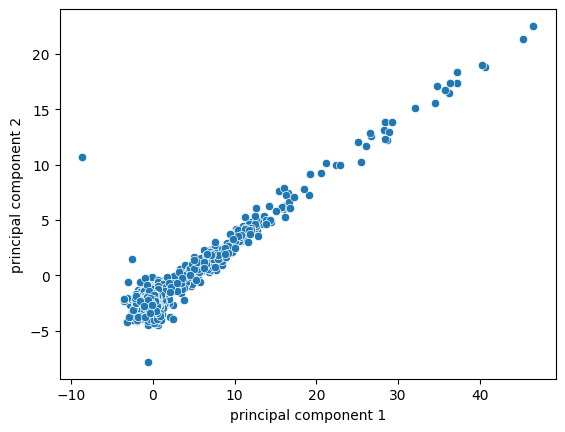

In [124]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

In [150]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7).fit(principal)
l = kmeans.labels_

In [151]:
import matplotlib.pyplot as plt

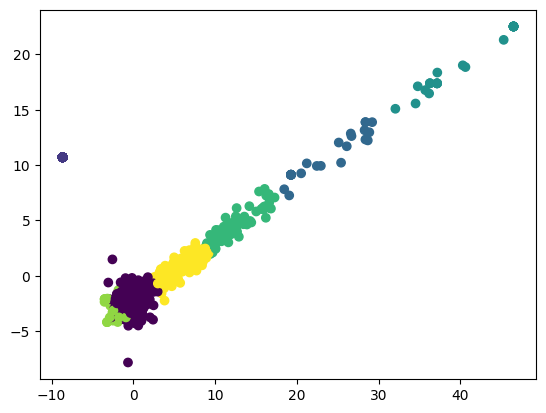

In [152]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

In [153]:
df['clust'] = l

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_37832/3423814712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clust'] = l


In [154]:
df.loc[df['clust']==1]['О себе']

22      ---
32      ---
34      ---
35      ---
50      ---
       ... 
2985    ---
2991    ---
2992    ---
2998    ---
2999    ---
Name: О себе, Length: 356, dtype: object

In [155]:
df.loc[df['clust']==0]['О себе']

0       Уверенный пользователь ПК, Ms Word, Ms Excel, ...
1       Энергична, активна, в поиске новых возможносте...
2       опыт прямых продаж, ведение коммерческих перег...
3       Коммуникабелен\nУмение работать с возражениями...
4       Дисциплина - умение выполнять поставленные зад...
                              ...                        
2988    Опыт управления более 15-и лет. Развитые управ...
2990    Аналитика продаж ,поиск клиентов,связь с произ...
2994    Многозадачность, стрессоустойчивость, инициати...
2995    Уверенный пользователь ПК: MS Office (Word, Ex...
2997                                                    .
Name: О себе, Length: 2057, dtype: object

In [156]:
df.loc[df['clust']==2]['О себе']

141     Легко и быстро обучаюсь, целеустремленная, вни...
154     Нацелена на результат. В интересные проекты по...
561     • Умею и люблю учиться;\n• Пунктуальна и дисци...
644     Личные качества:\nАктивный, общительный, легко...
730     Личные качества:\nАктивный, общительный, легко...
731     Люблю ответственность и ответственных людей, п...
927     - Аналитический склад ума;\n- Хорошие коммуник...
959     Молодой,Ответственный,Доброжелательный, способ...
979     Ответственная, целеустремленная, коммуникабель...
1126    Готова сразу приступить к работе.\n\nExcel- ув...
1298    На практике работаю с большими потоком докумен...
1425    Люблю путешествовать, 100 % коммуникабельность...
1439    Имею опыт работы в коллективе, организована, о...
1691    Я люблю интересную работу с возможностями разв...
1708    Целеустремленность, умение работать в команде ...
1905    я активный и очень общительный человек,быстро ...
1956    Москвич, семьянин, имею двоих детей, не склоне...
2306    Ответс

In [162]:
df.loc[df['clust']==2]['О себе'].shape

(27,)

In [164]:
df.loc[df['clust']==3]['О себе']

63      Общий стаж работы более 20 лет. Легко обучаюсь...
334     Добрый день. Немного обо мне: Успешное провиде...
373     Аналитический склад ума, высокая концентрация,...
414     Пунктуальная, исполнительная, мобильная.\nУмею...
649     Работал с людьми обладаю управлять командой зн...
837     Умею работать в режиме многозадачности, пункту...
1259    Люблю думать, создавать, видеть в своей работе...
1595    Здравствуйте, меня зовут Ксения.\nИз качеств о...
1651    Уравновешенный, целеустремленный, коммуникабел...
1723    Очень люблю автомобили, много читаю, в т.ч. те...
1766    Легко и быстро обучаюсь. Всегда стремлюсь узна...
1870    Имею опыт работы с web интерфейсами: backdase,...
1919    Активность, коммуникабельность, стрессоустойчи...
2106    Коммуникабельность,стрессоустойчивость,целеуст...
2164    Личные качества - целеустремленность, коммуник...
2227    Имею знания в области банковских технологий, и...
2254    Имею знания в области банковских технологий, и...
2353    Работа

In [165]:
df.loc[df['clust']==3]['О себе'].shape

(25,)

In [157]:
df.loc[df['clust']==4]['О себе']

30      Разбираюсь в новых системах и проектах, люблю ...
111     легко обучаема,целеустремленная,клиентоорентир...
150     Личные качества: отвественная, нацеленная на р...
253     Грамотный пользователь ПК\nРаботаю с: Пакетом ...
359     Продвинутый пользователь ПК: MS Office, графич...
                              ...                        
2868    Активный, энергичный, способный добиваться пос...
2903    Общительная, жизнерадостная, ответственная. Ан...
2963    Обладание сильным потенциалом и энергетикой. Л...
2974    Стресоустойчивый, ответственный, умею разобрат...
2980    ответственная, коммуникабельная, работаю в усл...
Name: О себе, Length: 80, dtype: object

In [158]:
df.loc[df['clust']==5]['О себе']

177     Увлечения: спорт, активный образ жизни.\nЛичны...
312     Интиллегентный, ответственный, целеустремлённы...
357     Способен решить в кратчайший срок все возникши...
358     Коммуникабельная, приятной наружности. Исполни...
453         Целеустремленный человек, с тягой познания...
531     Ответственный, стрессоустойчивый, креативный, ...
585     Ответственная, целеустремлённая, быстро схваты...
634     Ответственный, честный, усидчивый, стрессоусто...
678     Стремление к самообразованию. Требовательность...
685     Активная, увлекаюсь интеллектуальными играми, ...
686     Коммуникабелен, ответственен, настойчив в дост...
715     Аналитический, креативный склад ума, работоспо...
748                        Целеустремленная,пунктуальная.
781     туризм, спортивная рыбалка, книги, бадминтон.\...
792     Семейное положение: женат. дочь 9 лет.\nВодите...
832     Хоби, спорт, туризм, активный отдых, рыбалка о...
859     Аналитический склад ума, целеустремленный, раб...
901     личнос

In [161]:
df.loc[df['clust']==5]['О себе'].shape

(41,)

In [159]:
df.loc[df['clust']==6]['О себе']

29      Всегда полностью погружаюсь в рабочий процесс,...
33      Имею большой опыт в продажах. Работая в любом ...
82      Профессиональные навыки:\nExcel : сводные табл...
113     Придерживаюсь Data driven подхода к маркетингу...
120     - люблю много и результативно работать\n- ценю...
                              ...                        
2871    Навыки: Уверенный пользователь (Windows и Micr...
2920    В 2003 г. получила математическое образование,...
2975    Пользователь MS Office (Word, Excel, Internet)...
2982    Сильный бэкграунд, опыт работы в различных сфе...
2996    Моя потребность в постоянном улучшении себя на...
Name: О себе, Length: 139, dtype: object

In [160]:
np.unique(df['clust'])

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

Откуда берутся такие проблемы с mBART? Все же нужно брать что-то обученное не только на датасете gazeta. Мб это из-за Mars / BusinessForward / B,C — там какой-то сбой с эмбеддингами, юникодом итд...

In [180]:
print(df.loc[792, ['О себе', 'О себе, summarized']][0])

Семейное положение: женат. дочь 9 лет.
Водительские права категории В,С
Пунктуальный
Порядочный
Нацеленный на результат
Склонность к приобретению новых знаний
Умею управлять и работать в команде.
Тренинг:
Ключ к успеху (Mars)
Обучение на ИД (BuisinessForward)


In [181]:
print(df.loc[792, ['О себе', 'О себе, summarized']][1])

Встреча с президентом России Владимиром Путиным прошла накануне в Санкт-Петербурге. Встреча прошла в присутствии президента РФ Владимира Путина и президента США Дональда Трампа.


In [184]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x]['О себе'].shape[0])

1 : 2057
2 : 356
3 : 27
4 : 25
5 : 80
6 : 41
7 : 139


In [193]:
print(df.loc[df['clust']==5]['О себе'].loc[792])

Семейное положение: женат. дочь 9 лет.
Водительские права категории В,С
Пунктуальный
Порядочный
Нацеленный на результат
Склонность к приобретению новых знаний
Умею управлять и работать в команде.
Тренинг:
Ключ к успеху (Mars)
Обучение на ИД (BuisinessForward)


Хм, то есть, тут кластер плохих преобразований mBART'ом?

In [195]:
df.loc[df['clust']==5]['О себе, summarized']

177     Встреча с кандидатом в президенты России Влади...
312     Встреча с президентом России Владимиром Путины...
357     Встреча с президентом России Владимиром Путины...
358     Встреча с президентом России Владимиром Путины...
453     Встреча с президентом России Владимиром Путины...
531     Встреча с новым президентом России Владимиром ...
585     Гражданин России, проживающий в Санкт-Петербур...
634     Встреча с президентом России Владимиром Путины...
678     Встреча с президентом России Владимиром Путины...
685     Гражданин России, проживающий в Санкт-Петербур...
686     Встреча с президентом России Владимиром Путины...
715     Встреча с президентом России Владимиром Путины...
748     Встреча с президентом России Владимиром Путины...
781     Встреча с президентом России Владимиром Путины...
792     Встреча с президентом России Владимиром Путины...
832     Встреча с президентом России Владимиром Путины...
859     Встреча с президентом России Владимиром Путины...
901     Встреч

Тут про поиск работы[:

In [196]:
df.loc[df['clust']==6]['О себе, summarized']

29      Нахожусь в поисках работы, в которой смогу при...
33      В одном из московских салонов открылась вакант...
82      На данный момент я работаю в компании, которая...
113     В настоящее время я работаю в сфере маркетинга...
120     В настоящее время работаю в сфере программиров...
                              ...                        
2871    Нахожусь в возрасте 35 лет в компании, занимаю...
2920    Germany. Нахожусь в поисках работы в сфере про...
2975    Нахожусь в отпуске по уходу за ребенком. На да...
2982    Нахожусь в поисках работы, которая позволит мн...
2996    Нахожусь в поисках работы, которая будет требо...
Name: О себе, summarized, Length: 139, dtype: object

Тут работают:

In [197]:
df.loc[df['clust']==4]['О себе, summarized']

30      Нахожусь в поисках работы. На данный момент я ...
111     На данный момент я работаю в компании, которая...
150     На данный момент я работаю в одном из крупнейш...
253     На данный момент я работаю в компании, которая...
359     На данный момент я работаю в одном из крупнейш...
                              ...                        
2868    Нахожусь в поисках работы в сфере логистики и ...
2903    На данный момент я работаю в сфере маркетинга,...
2963    На данный момент я работаю в одном из самых пр...
2974    На данный момент я работаю в сфере юридической...
2980    Нахожусь в поисках работы в одном из московски...
Name: О себе, summarized, Length: 80, dtype: object

Тут что-то еще:

In [202]:
df.loc[df['clust']==3]['О себе, summarized']

63      Нахожусь в поисках работы. На данный момент ра...
334     Нахожусь в поисках работы. На данный момент я ...
373     Нахожусь в поисках работы. На данный момент ра...
414     Нахожусь в поисках работы. На данный момент ра...
649     Нахожусь в поисках работы. На данный момент ра...
837     Нахожусь в поисках работы. На данный момент ра...
1259    Нахожусь в поисках работы. На данный момент ра...
1595    Нахожусь в поисках работы. На данный момент ра...
1651    Нахожусь в поисках работы. На данный момент ра...
1723    Нахожусь в поисках работы. На данный момент ра...
1766    Нахожусь в поисках работы. На данный момент ра...
1870    Нахожусь в поисках работы. На данный момент ра...
1919    Нахожусь в поисках работы. На данный момент ра...
2106    Нахожусь в поисках работы. На данный момент ра...
2164    Нахожусь в поисках работы. На данный момент ра...
2227    Нахожусь в поисках работы. На данный момент ра...
2254    Нахожусь в поисках работы. На данный момент ра...
2353    Нахожу

In [203]:
df.loc[df['clust']==3]['О себе, summarized'].iloc[3]

'Нахожусь в поисках работы. На данный момент работаю в одном из московских офисов.'

In [204]:
df.loc[df['clust']==3]['О себе, summarized'].iloc[2]

'Нахожусь в поисках работы. На данный момент работаю в сфере маркетинга, рекламы и продаж.'

Хм интересно будет все это подробнее рассмотреть!

Хм вот поэтому нужно посмотреть на картину с другими признаками... В общем все ясно!! Здесь только какая-то базовая информация которая возможно не укладывается в другие признаки. Но опять же в силу количества признаков у нас и О себе summarized и Образование итд не должны по отдельности сильно на что-то влиять (как проверить это точными методами?)

Только вознкиает проблема: KMeans плохо работает в больших размерностях как у меня, надо пробовать ЕМ-алгоритм... Сослаться на ту статью про curse of dimensionality у MSE на котором основан KMeans, которую я где-то у себя сохранял...

Буду размечать: (надо где-то 10% ~ 270, но постараюсь и побольше, потом когда снова будет муд не на рутинную разметку а на МЛ обучу модель)

In [210]:
df.sample(335).loc[:, ['Ссылка', 'Название']].to_csv('to_markup.txt')

In [ ]:
df.sample(1).loc[:, ['Ссылка', 'Название']]

### Далее

Итак, для начала импортируем нашу табличку, полученную в ноутбуке `preprocessing.ipynb`.

Посмотрим на первые 100 резюме, чтобы понять, как выглядит наша таблица:

In [150]:
df = pd.read_csv('resumes_features.csv')
df.head(100)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Ссылка,Название,Коммандировка,"Опыт работы, лет",О себе,Образование,...,Коммандировка?,Город?,Аналитические комбинации слов,Справочник по интересам,Карьерный рост,"О себе, summarized","О себе, tokens","О себе, flat_tokens","О себе, 3-grams","О себе, avg_tokens"
0,0,1,1,1,https://hh.ru/resume/628596ac000657935b0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к редким ...",Опыт работы 1 год 5 месяцев,В последние годы проходила обучение без возмож...,Высшее образование (Бакалавр)\n2022\nНациональ...,...,не готова к переезду,Москва,---,found smt by rule (Analyst)|(Аналитик данных)|...,True,"Гражданин России, проживающий в Санкт-Петербур...","[array([ 4.2191329e-03, 3.8639535e-04, -8.798...",[ 2.95168342e-04 -1.54395448e-03 -1.38613814e-...,"['последний год проходить', 'год проходить обу...",-0.000129
1,1,2,2,2,https://hh.ru/resume/dfbcae000004342d8f0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к команди...",Опыт работы 3 года 3 месяца,---,Высшее образование (Бакалавр)\n2019\nСамарский...,...,не готова к переезду,Москва,---,found smt by rule (Analyst)|(Аналитик данных)|...,False,---,"[array([-8.6196875e-03, 3.6657380e-03, 5.189...",[-8.6196875e-03 3.6657380e-03 5.1898835e-03 ...,-,0.000681
2,2,3,3,3,https://hh.ru/resume/bebf6a630008069d8c0039ed1...,Аналитик,"Санкт-Петербург, м. Гражданский проспект, гото...",Опыт работы 7 лет 2 месяца,Имею экономическое образование. Продвинутый по...,Высшее образование (Бакалавр)\n2015\nСанкт-Пет...,...,готов к переезду,Санкт,found smt by rule (SQL)|(Excel)|(Python)|(Tabl...,found smt by rule (Analyst)|(Аналитик данных)|...,False,На данный момент не нахожусь на территории РФ....,"[array([-0.00577433, -0.00298019, 0.00639458,...",[-1.1685997e-03 1.2998827e-03 -2.5936777e-03 ...,"['иметь экономический образование', 'экономиче...",-0.000146
3,3,4,4,4,https://hh.ru/resume/8606f37b000773de980039ed1...,Программист-разработчик,"Москва, м. Петровско-Разумовская, не готов к п...",Опыт работы 1 год 1 месяц,Имеется опыт в создании Android-приложений на ...,Высшее образование (Бакалавр)\n2022\nЧелябинск...,...,не готов к переезду,Москва,found smt by rule (SQL)|(Excel)|(Python)|(Tabl...,---,False,В настоящее время я работаю в сфере разработки...,"[array([-8.7200766e-03, 9.9531859e-03, -2.345...",[-4.07442392e-04 5.87383693e-04 8.51579127e-...,"['иметься опыт создание', 'опыт создание andro...",0.000049
4,4,5,5,5,https://hh.ru/resume/993bd0980002dd6cff0039ed1...,Аналитик Bi,"Москва, м. Сокол, готов к переезду, готов к ко...",Опыт работы 10 лет 7 месяцев,Уверенный пользователь.\nЖелание оптимизации и...,Высшее образование\n2010\nДальневосточный госу...,...,готов к переезду,Москва,found smt by rule (SQL)|(Excel)|(Python)|(Tabl...,found smt by rule (Analyst)|(Аналитик данных)|...,False,"Уверенный пользователь Microsoft Dynamics AX, ...","[array([ 6.2332065e-03, -1.6407053e-03, 5.968...",[-3.7161107e-04 2.3680142e-04 -1.6213297e-04 ...,"['уверенный пользователь желание', 'пользовате...",-0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,62,69,69,69,https://hh.ru/resume/15abcb4a000902e72c0039ed1...,Аналитик,"Москва, готов к переезду, готов к командировкам",Опыт работы 1 год 6 месяцев,В последние годы я проходил обучение без возмо...,Высшее образование (Бакалавр)\n2022\nРоссийски...,...,готов к переезду,Москва,found smt by rule (SQL)|(Excel)|(Python)|(Tabl...,found smt by rule (Analyst)|(Аналитик данных)|...,False,NaN,"[array([ 4.2191329e-03, 3.8639535e-04, -8.798...",[-4.9789756e-04 -5.4419227e-04 -2.5611392e-03 ...,"['последний год проходить', 'год проходить обу...",-0.000504
63,63,70,70,70,https://hh.ru/resume/e1b370df0007951de20039ed1...,Аналитик,"Москва, м. Лермонтовский проспект, готов к пер...",Опыт работы 20 лет 5 месяцев,"владею инструментарием обработки, анализа и ви...",Высшее образование (Магистр)\n2007\nМосковский...,...,готов к переезду,Москва,---,found smt by rule (Analys

Разметка данных ручная:

In [151]:
df1 = df.head(100)

In [152]:
df1['analyst'] = [0, 1, 2, 2ZZZ, 1, 0, 2, 1, 0, 1, 2] + 89 * [0]
df1['scientist'] = [0, 0, 0, 0, 0, 1, 1, 1] + 92 * [0]

SyntaxError: invalid syntax (1010328942.py, line 1)

In [153]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [154]:
X = df1[['Кол-во образований', 'Кол-во образований']]

In [155]:
y = df1['analyst']

KeyError: 'analyst'

In [156]:
reg = LinearRegression()

In [157]:
reg.fit(X, y)

NameError: name 'y' is not defined

In [158]:
reg.score(X, y)

NameError: name 'y' is not defined

In [159]:
reg.coef_

AttributeError: 'LinearRegression' object has no attribute 'coef_'

**Итак, текст размечен для классификации. Теперь сегментация по "О себе".**

pre-processing

Кластеризуем:

In [264]:
df = pd.read_csv('resumes_features.csv')

In [265]:
X = df['О себе, flat_tokens']

In [266]:
for i in range(len(X)):
    # print(i)
    X[i] = X[i].replace('\n', '').replace('[ ', '').replace(' ]', '').replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').replace('[', '').replace(']', '').split(' ')
    X[i] = [float(i) for i in X[i]]

/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_9955/3779291681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i] = X[i].replace('\n', '').replace('[ ', '').replace(' ]', '').replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').replace('[', '').replace(']', '').split(' ')
/var/folders/0k/pk7zyw6x2sqcjpbqvgf0ssh80000gn/T/ipykernel_9955/3779291681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i] = [float(i) for i in X[i]]


In [289]:
pd.DataFrame(X)['О себе, flat_tokens']

0     [0.000295168342, -0.00154395448, -0.0013861381...
1     [-0.0086196875, 0.003665738, 0.0051898835, 0.0...
2     [-0.0011685997, 0.0012998827, -0.0025936777, 0...
3     [-0.000407442392, 0.000587383693, 0.0008515791...
4     [-0.00037161107, 0.00023680142, -0.00016213297...
                            ...                        
62    [-0.00049789756, -0.00054419227, -0.0025611392...
63    [-0.00211551553, -0.000514384184, 0.0004572586...
64    [7.9651163e-06, 2.841573e-05, 0.00020546571, 0...
65    [0.00088479457, 0.00048863521, 0.00014909195, ...
66    [-6.5130975e-05, -0.00063547277, -0.0009241980...
Name: О себе, flat_tokens, Length: 67, dtype: object

In [288]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(
                init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=42
            )

kmeans.fit(pd.DataFrame(X))

ValueError: setting an array element with a sequence.

In [40]:
for x in embs_flattened:
    print(len(x))

NameError: name 'embs_flattened' is not defined

Почитать:

Тоже уменьшить как-то размер ноутбука

In [16]:
kmeans.labels_

array([2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2,
       2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0,
       2, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2,
       0], dtype=int32)

In [17]:
# kmeans.predict([[0, 0], [12, 3]])

In [18]:
np.unique(kmeans.labels_)

array([0, 1, 2], dtype=int32)

In [19]:
X

,Кол-во образований,Кол-во образований
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
62,1,1
63,2,2
64,2,2
65,1,1


t-sne analysis

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
x = scaler.fit_transform(X)

In [21]:
x

array([[-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [ 2.83790882,  2.83790882],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [ 1.9367719 ,  1.9367719 ],
       [-0.76663888, -0.76663888],
       [ 1.03563497,  1.03563497],
       [ 0.13449805,  0.13449805],
       [-0.76663888, -0.76663888],
       [ 0.13449805,  0.13449805],
       [ 1.03563497,  1.03563497],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [ 0.13449805,  0.13449805],
       [-0.76663888, -0.76663888],
       [-0.76663888, -0.76663888],
       [ 0.13449805,  0.13449805],
       [ 0.13449805,  0.13449805],
       [-0.76663888, -0.76663888],
       [ 0.13449805,  0.13449805],
       [ 0.13449805,  0.13449805],
       [ 0.13449805,

In [22]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

In [23]:
pca.explained_variance_ratio_[:2].sum()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [24]:
principal

NameError: name 'principal' is not defined

In [25]:
import seaborn as sns

In [26]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

NameError: name 'principal' is not defined

In [64]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(principal)
l = kmeans.labels_

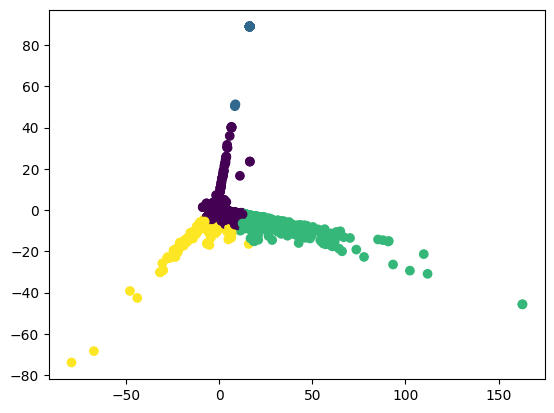

In [71]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

In [67]:
df['clust'] = l

In [73]:
df.loc[df['clust']==1]['О себе']

69       В последние годы я проходил обучение без возмо...
178      В последние годы проходил обучение без возможн...
324      В последние годы проходил обучение без возможн...
911      В последние годы я проходила обучение без возм...
1750     В последние годы я проходил обучение без возмо...
                               ...                        
19638    В последние годы я проходил обучение без возмо...
19645    В последние годы проходил обучение без возможн...
19667    В последние годы я проходил обучение без возмо...
19728    В последние годы я проходил обучение без возмо...
19765    В последние годы проходила обучение без возмож...
Name: О себе, Length: 67, dtype: object

In [74]:
df.loc[df['clust']==0]['О себе']

0        Responsible, communicable, quick study and det...
1        В последние годы проходила обучение без возмож...
2                                                      ---
3        Имею экономическое образование. Продвинутый по...
4        Имеется опыт в создании Android-приложений на ...
                               ...                        
19813    Высокая работоспособность, вдумчивость, уравно...
19814    Увлекаюсь спортом, вредные привычки отсутствую...
19815    Уверенный пользователь ПК, работа с оргтехнико...
19816    Я абсолютно честен и очень ответственен. Люблю...
19817    I. ОБЩАЯ ПОДГОТОВЛЕННОСТЬ И ОПЫТ РАБОТЫ\n\nДел...
Name: О себе, Length: 18774, dtype: object

In [75]:
df.loc[df['clust']==2]['О себе']

21       Аналитический склад ума, ответственная, пункту...
40       Ответственный, исполнительный, целеустремленны...
83       Аналитический склад ума, критическое мышление,...
114      Аналитический склад ума, ответственность, стре...
122      Аналитический склад ума. Системное мышление. Ц...
                               ...                        
19753    Аналитический склад ума, умение работать в ком...
19771    Стрессоустойчивость, коммуникабельность, спосо...
19776    Стрессоустойчивость, обучаемость, работа с бол...
19782    умение работать в команде, общительность, целе...
19788    Я быстро обучаюсь, всегда концентрирован на за...
Name: О себе, Length: 641, dtype: object

In [76]:
df.loc[df['clust']==4]['О себе']

Series([], Name: О себе, dtype: object)

итог: кластеры плохие, мб как раз дело в том, что слишком простой метод постреония эмбеддингов

In [ ]:
df.iloc[0]['Ссылка']

**что дальше?**

- 3 ноутбука с содержанием
- разметка, образование
- эксперименты с эмбеддингами [в таблице q | emb_w2v | emd d2v | etc.], моделями, учусь сравнивать supervised и semi-supervised

Сравнение:
- https://stats.stackexchange.com/questions/498580/semi-supervised-learning-vs-supervised
- https://ifoadatascienceresearch.github.io/tutorial/comparison/
- https://math.stackexchange.com/questions/3927928/semisupervised-vs-supervised-learning

Интерпретировать результаты.